In [127]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *

In [128]:
np.random.seed(0)
def get_surgery_time(mean,std):
    sh,sc = (mean/std)**2,std**2/mean
    return np.random.gamma(shape=sh,scale=sc)

In [129]:
#problem parameters
specs = ['CARD','GASTRO','GYN','MED','ORTHO','URO']

surgery_data = {'CARD':[99.0,53.0],'GASTRO':[132.0,76.0],'GYN':[78.0,52.0],'MED':[75.0,32.0],'ORTHO':[142.0,58.0],'URO':[72.0,38.0]}

blocks = {'CARD':[2,6,16,28,32,33],'GASTRO':[1,8,14,15,22,27,34],'GYN':[4,11,12,18,19,24,25,30,35],'MED':[17,36],'ORTHO':[3,9,10,21,23,29,37],'URO':[5,7,13,20,26,31,38]}
block_len = [8 for i in range(32)]+[60 for i in range(len(specs))]
n_blocks = len(block_len)

n_surgeries = 200
percent_surg = {'CARD':14,'GASTRO':18,'GYN':28,'MED':5,'ORTHO':17,'URO':18}
surgeries = {}
tot = 0
for i in specs[:len(specs)-1]:
    surgeries[i] = round(n_surgeries*percent_surg[i]/100.0)
    tot += surgeries[i]
surgeries[specs[-1]] = n_surgeries-tot

surgery_nums = {}
t = 0
for s in specs:
    surgery_nums[s] = [t,t+surgeries[s]-1]
    t = t+surgeries[s]
    
print(surgeries)
print(surgery_nums)

{'CARD': 28, 'GASTRO': 36, 'GYN': 56, 'MED': 10, 'ORTHO': 34, 'URO': 36}
{'CARD': [0, 27], 'GASTRO': [28, 63], 'GYN': [64, 119], 'MED': [120, 129], 'ORTHO': [130, 163], 'URO': [164, 199]}


In [145]:
#costs
cib = np.array([[np.random.randint(low=1,high=5)*100 for _ in range(n_blocks)] for _ in range(n_surgeries)]) # block costs
dummy_cost = 1000
for i in range(n_surgeries):
    for b in range(32,38):
        cib[i,b] = dummy_cost

cob = np.array([10.0 for _ in range(n_blocks)])
cgb = np.array([10.0/1.5 for _ in range(n_blocks-len(specs))]+[0.0 for _ in range(len(specs))])

print(cib[0])

IndexError: index 32 is out of bounds for axis 1 with size 1

In [131]:
#block and surgery of a speciality fesibility
p = [[0 for _ in range(n_blocks)] for _ in range(n_surgeries)]
p = np.array(p)
t = 0
for s in specs:
    for i in range(surgeries[s]):
        for b in blocks[s]:
            p[t,b-1] = 1
        t += 1

In [132]:
n_scenarios = 10**3
avg_model = ConcreteModel()
avg_model.y = Var(RangeSet(n_surgeries),RangeSet(n_blocks),domain=Binary)
avg_model.o = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)
avg_model.g = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)

avg_model.atmost1 = ConstraintList()
for i in range(n_surgeries):
    avg_model.atmost1.add(expr=sum(avg_model.y[i+1,b] for b in range(1,n_blocks+1))==1)

avg_model.specfeas = ConstraintList()
for i in range(n_surgeries):
    for b in range(n_blocks):
        avg_model.specfeas.add(expr=avg_model.y[i+1,b+1] <= p[i,b])

avg_model.ogcons = ConstraintList()
for n in range(n_scenarios):
    t = 0
    for s in specs:
        for b in blocks[s]:
            avg_model.ogcons.add(expr=avg_model.o[b,n+1]-avg_model.g[b,n+1] == sum(get_surgery_time(surgery_data[s][0],surgery_data[s][1])*avg_model.y[i+1,b] for i in range(surgery_nums[s][0],surgery_nums[s][1]+1))-block_len[b-1])

avg_model.cost = Objective(expr=sum(sum(avg_model.y[i+1,b+1]*cib[i,b] for i in range(n_surgeries)) for b in range(n_blocks))+(sum(cob[b]*avg_model.o[b+1,n+1]+cgb[b]*avg_model.g[b+1,n+1] for b in range(n_blocks) for n in range(n_scenarios)))/n_scenarios,sense=minimize)

In [133]:
opt = SolverFactory('cplex')
result = opt.solve(avg_model,tee=True)
print("Solver status :",result.solver.status)
print("Solver Termination condition :", result.solver.termination_condition)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\91824\AppData\Local\Temp\tmpyvhoeb5g.cplex.log' open.
CPLEX> Problem 'C:\Users\91824\AppData\Local\Temp\tmp_zq_2ju3.pyomo.lp' read.
Read time = 0.56 sec. (24.79 ticks)
CPLEX> Problem name         : C:\Users\91824\AppData\Local\Temp\tmp_zq_2ju3.pyomo.lp
Objective sense      : Minimize
Variables            :   83601  [Nneg: 76001,  Binary: 7600]
Objective nonzeros   :   77600
Linear constraints   :   45801  [Less: 7600,  Equal: 38201]
  Nonzeros           : 1525201
  RHS nonzeros       :   39635

Variables            : Min LB: 0.000000         Max UB: 1.000000       
Objective nonzeros 

In [134]:
l = [[] for _ in range(n_blocks)]
for b in range(n_blocks):
    for i in range(n_surgeries):
        if avg_model.y[i+1,b+1].value > 0.0:
            l[b].append(i)

for i in range(len(l)):
    print("Block :",i+1, 'Surgeries',l[i])
    

Block : 1 Surgeries [30, 42, 54, 58, 63]
Block : 2 Surgeries [2, 10, 12, 14, 27]
Block : 3 Surgeries [135, 137, 139, 140, 153, 162]
Block : 4 Surgeries [65, 73, 85, 95, 106, 111, 115, 118]
Block : 5 Surgeries [168, 170, 178, 179, 180, 185, 186, 192]
Block : 6 Surgeries [6, 7, 9, 17, 21, 22, 25]
Block : 7 Surgeries [166, 184, 194, 197]
Block : 8 Surgeries [28, 40, 43, 44, 45, 53, 57, 59]
Block : 9 Surgeries [142, 144, 159, 161]
Block : 10 Surgeries [134, 146, 150, 151, 156]
Block : 11 Surgeries [64, 66, 77, 79, 84, 93, 96, 97, 114]
Block : 12 Surgeries [76, 78, 82, 99, 100, 112]
Block : 13 Surgeries [165, 175, 181, 187, 190, 198, 199]
Block : 14 Surgeries [31, 34, 38, 48, 49]
Block : 15 Surgeries [29, 32, 41, 47, 52, 56, 61]
Block : 16 Surgeries [0, 8, 15, 19, 23, 26]
Block : 17 Surgeries [120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
Block : 18 Surgeries [69, 72, 90, 92, 108]
Block : 19 Surgeries [71, 75, 81, 83, 94, 98, 102, 107, 109, 116, 117, 119]
Block : 20 Surgeries [169, 174,

In [135]:
surgery_nums

{'CARD': [0, 27],
 'GASTRO': [28, 63],
 'GYN': [64, 119],
 'MED': [120, 129],
 'ORTHO': [130, 163],
 'URO': [164, 199]}

In [136]:
for i in specs:
    print(i, blocks[i])

CARD [2, 6, 16, 28, 32, 33]
GASTRO [1, 8, 14, 15, 22, 27, 34]
GYN [4, 11, 12, 18, 19, 24, 25, 30, 35]
MED [17, 36]
ORTHO [3, 9, 10, 21, 23, 29, 37]
URO [5, 7, 13, 20, 26, 31, 38]


In [137]:
os = [[] for _ in range(n_blocks)]
gs = [[] for _ in range(n_blocks)]

for b in range(n_blocks):
    for n in range(n_scenarios):
        os[b].append(avg_model.o[b+1,n+1].value)
        gs[b].append(avg_model.g[b+1,n+1].value)

os = np.array(os)
gs = np.array(gs)

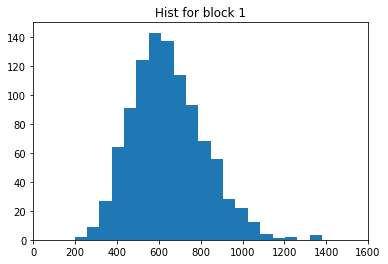

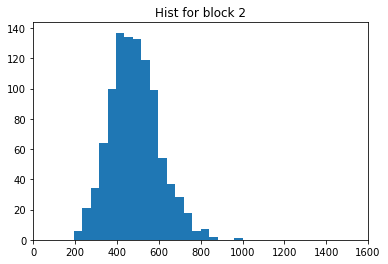

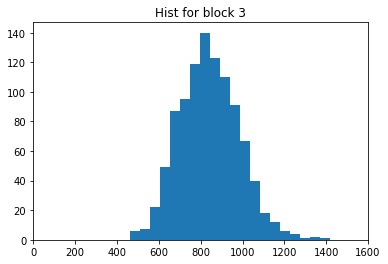

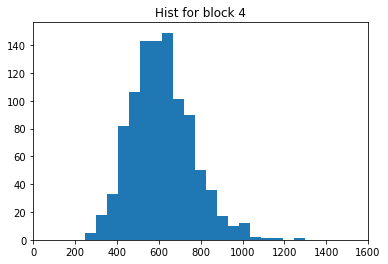

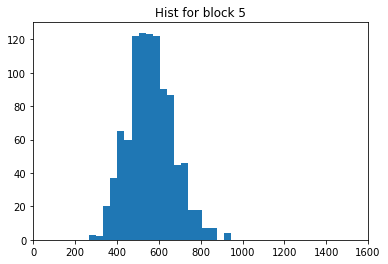

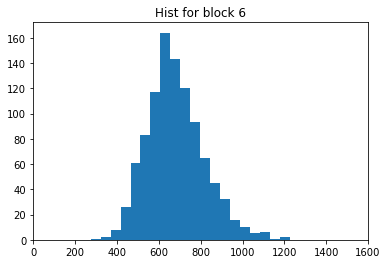

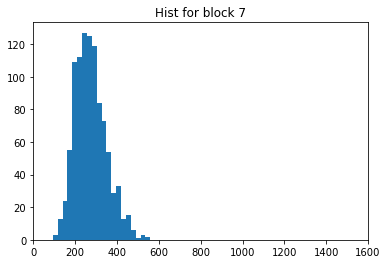

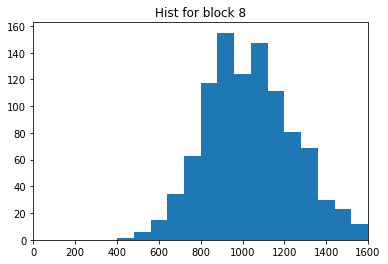

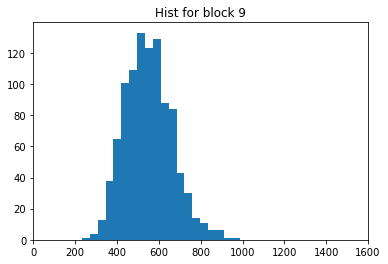

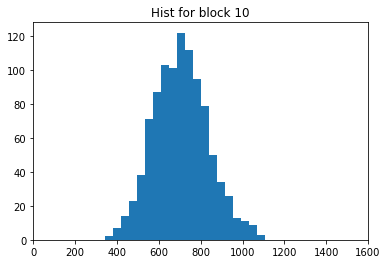

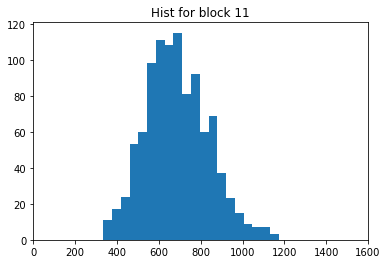

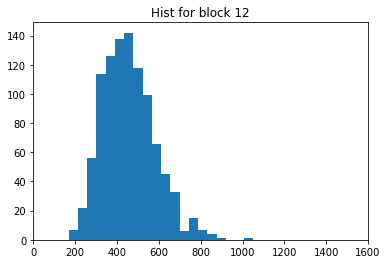

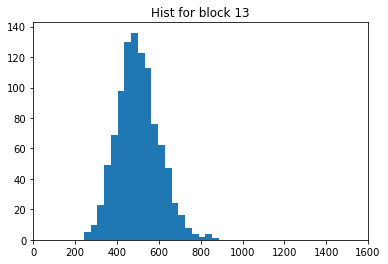

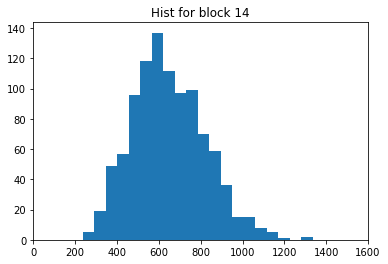

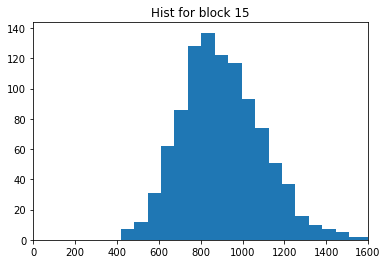

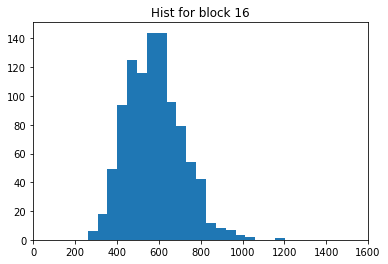

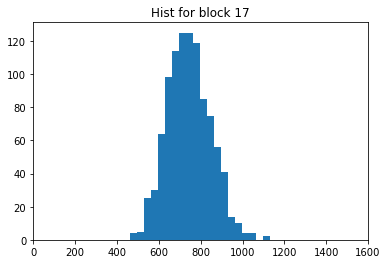

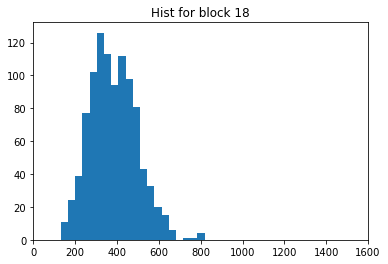

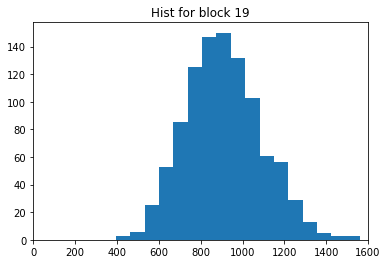

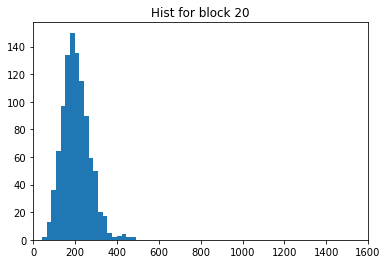

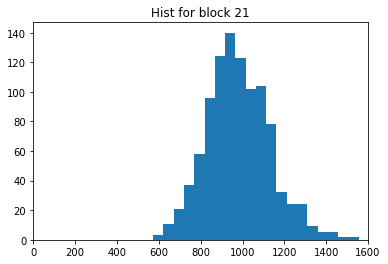

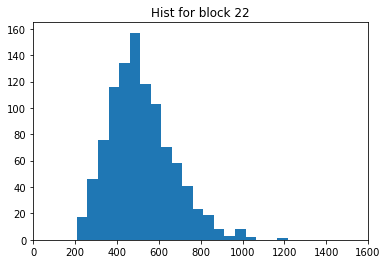

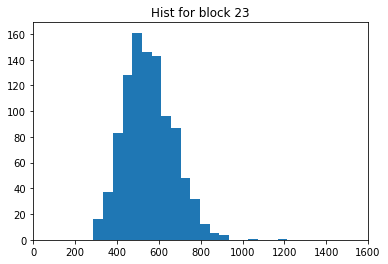

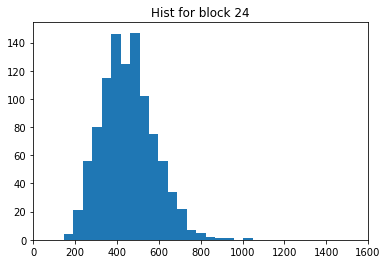

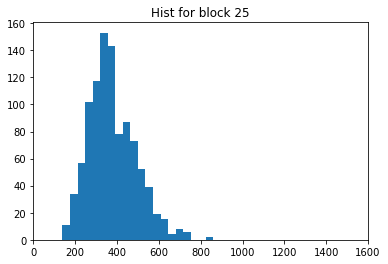

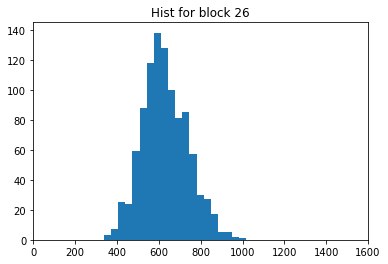

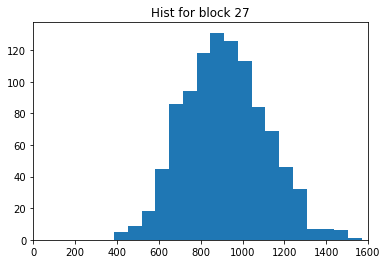

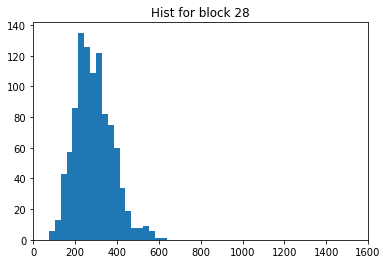

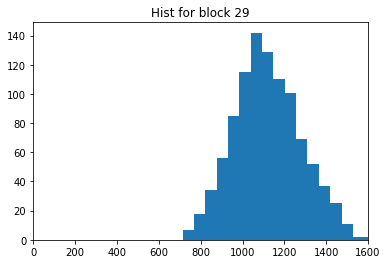

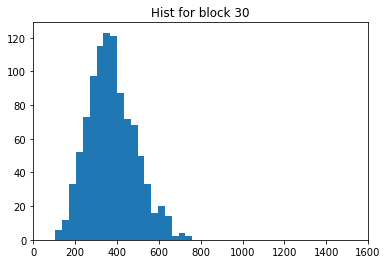

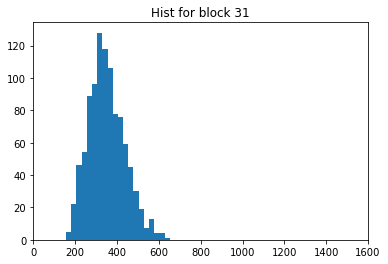

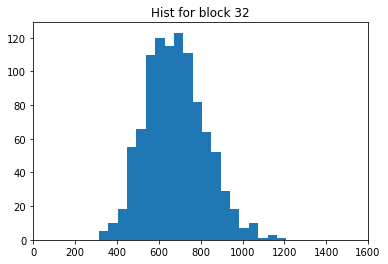

In [138]:
overtime = os-gs

for b in range(n_blocks-len(specs)):
    plt.figure()
    plt.title("Hist for block "+str(b+1))
    plt.hist(overtime[b],bins=20)
    plt.xlim(0,1600)
    plt.show()

In [139]:
cib

array([[ 100,  400,  200, ..., 1000, 1000, 1000],
       [ 400,  100,  300, ..., 1000, 1000, 1000],
       [ 400,  100,  200, ..., 1000, 1000, 1000],
       ...,
       [ 200,  300,  400, ..., 1000, 1000, 1000],
       [ 400,  300,  100, ..., 1000, 1000, 1000],
       [ 200,  200,  100, ..., 1000, 1000, 1000]])

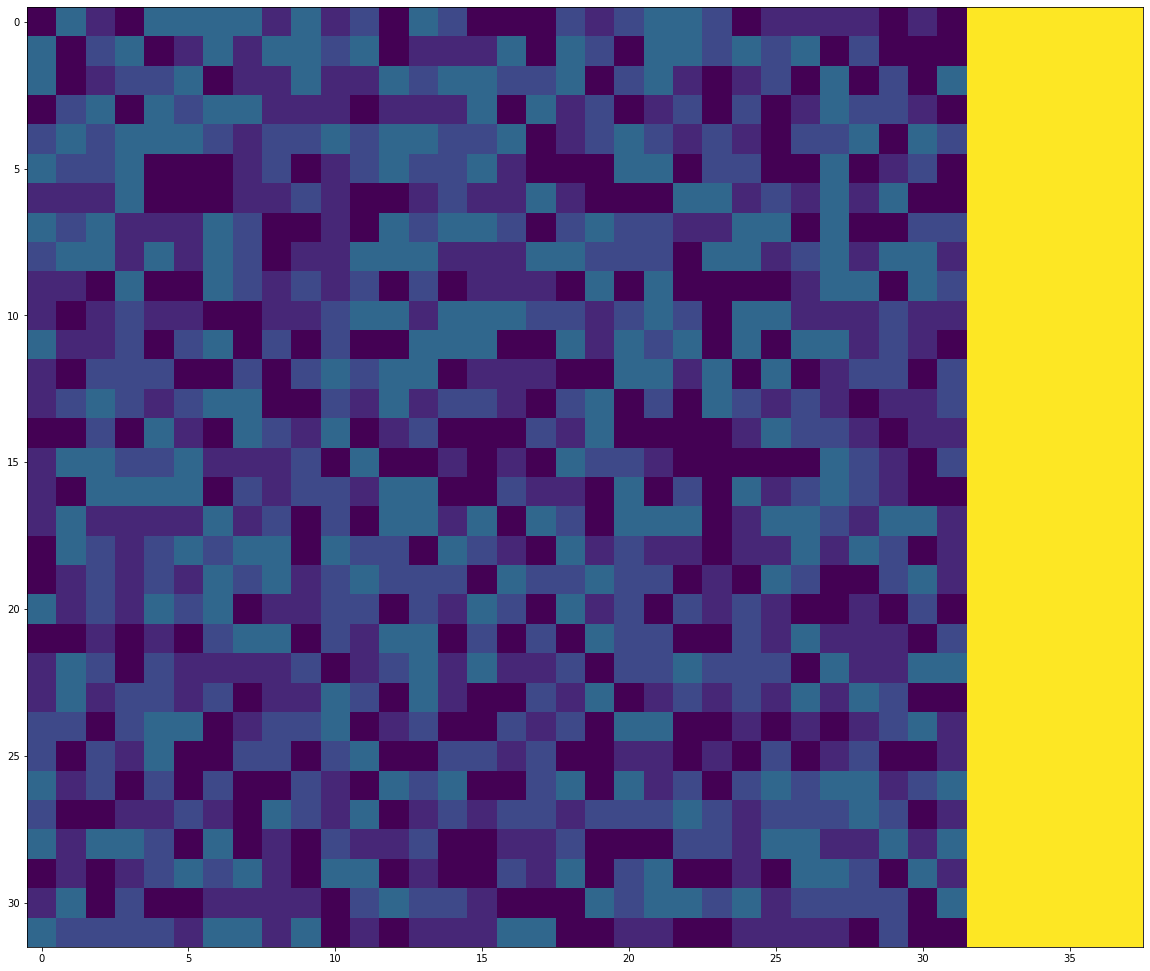

In [140]:
plt.figure(figsize=(20,20))
plt.imshow(cib[:][:32],interpolation='nearest')

In [141]:
cib.shape

(200, 38)

In [142]:
cib[:2][:32]

array([[ 100,  400,  200,  100,  400,  400,  400,  400,  200,  400,  200,
         300,  100,  400,  300,  100,  100,  100,  300,  200,  300,  400,
         400,  300,  100,  200,  200,  200,  200,  100,  200,  100, 1000,
        1000, 1000, 1000, 1000, 1000],
       [ 400,  100,  300,  400,  100,  200,  400,  200,  400,  400,  300,
         400,  100,  200,  200,  200,  400,  100,  400,  300,  100,  400,
         400,  300,  400,  300,  400,  100,  300,  100,  100,  100, 1000,
        1000, 1000, 1000, 1000, 1000]])